In [1]:
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
import os

from pymoo.core.problem import StarmapParallelization
from pymoo.algorithms.moo.age2 import AGEMOEA2
from pymoo.decomposition.asf import ASF
from auto_robot_design.optimization.saver import (ProblemSaver)
from auto_robot_design.description.utils import draw_joint_point
from auto_robot_design.optimization.problems import MultiCriteriaProblem
from auto_robot_design.optimization.optimizer import PymooOptimizer
from auto_robot_design.pinokla.calc_criterion import ActuatedMass, EffectiveInertiaCompute, MovmentSurface, NeutralPoseMass, ManipJacobian
from auto_robot_design.pinokla.criterion_agregator import CriteriaAggregator
from auto_robot_design.pinokla.default_traj import add_auxilary_points_to_trajectory, convert_x_y_to_6d_traj_xz, get_vertical_trajectory, create_simple_step_trajectory, get_workspace_trajectory
from auto_robot_design.optimization.rewards.reward_base import PositioningConstrain, PositioningErrorCalculator, RewardManager
from auto_robot_design.optimization.rewards.jacobian_and_inertia_rewards import HeavyLiftingReward, MinAccelerationCapability
from auto_robot_design.description.builder import ParametrizedBuilder, DetailedURDFCreatorFixedEE, jps_graph2pinocchio_robot, MIT_CHEETAH_PARAMS_DICT
from auto_robot_design.generator.topologies.graph_manager_2l import GraphManager2L,get_preset_by_index
from auto_robot_design.generator.topologies.bounds_preset import get_preset_by_index_with_bounds
import pinocchio as pin



In [2]:
thickness = MIT_CHEETAH_PARAMS_DICT["thickness"]
actuator = MIT_CHEETAH_PARAMS_DICT["actuator"]
density = MIT_CHEETAH_PARAMS_DICT["density"]
body_density = MIT_CHEETAH_PARAMS_DICT["body_density"]


builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE,
                              density={"default": density, "G": body_density},
                              thickness={"default": thickness, "EE": 0.033},
                              actuator={"default": actuator},
                              size_ground=np.array(
                                  MIT_CHEETAH_PARAMS_DICT["size_ground"]),
                              offset_ground=MIT_CHEETAH_PARAMS_DICT["offset_ground_rl"]
                              )

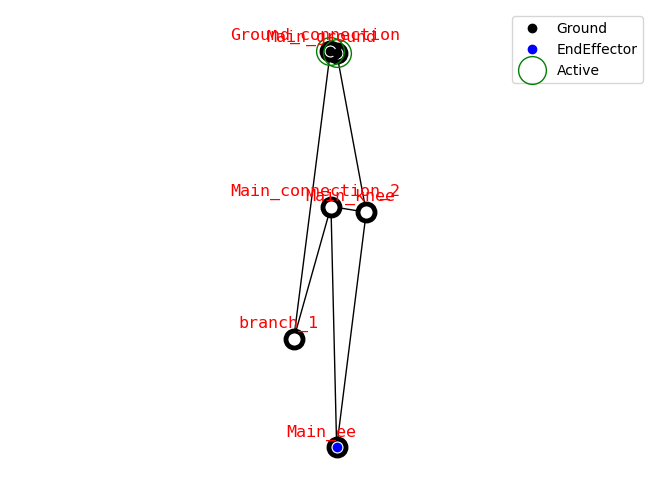

In [3]:
topology_index = 0
gm = get_preset_by_index_with_bounds(topology_index)
graph = gm.get_graph(np.array([-0.0063,  0.0023, -0.1615,  0.1506,  0.5051, -0.0372, -0.2922]))
#graph = gm.get_graph(np.array([-0.0063,  0.0023, -0.1615,  0.1,  0.4, -0.0372, -0.2922]))
#graph=gm.get_graph(gm.generate_central_from_mutation_range())
draw_joint_point(graph)


#np.array([-0.0063,  0.0023, -0.1615,  0.1506,  0.5051, -0.0372, -0.2922])

In [4]:
gm.mutation_ranges

{'Ground_connection_0': (-0.2, 0.0),
 'Ground_connection_2': (-0.028999999999999998, 0.07100000000000001),
 'Main_knee_2': (-0.30000000000000004, -0.1),
 'Main_connection_2_0': (-0.2, 0.2),
 'Main_connection_2_2': (-0.3, 0.6),
 'branch_1_0': (-0.05, 0.1),
 'branch_1_2': (-0.3, -0.1)}

In [6]:
node = gm.get_node_by_name("Main_ee")
node.r


array([ 0. ,  0. , -0.4])

In [5]:
# 1) trajectories

workspace_trajectory = convert_x_y_to_6d_traj_xz(
    *get_workspace_trajectory([-0.12, -0.33], 0.09, 0.24, 30, 60))


ground_symmetric_step1 = convert_x_y_to_6d_traj_xz(*add_auxilary_points_to_trajectory(create_simple_step_trajectory(
    starting_point=[-0.11, -0.32], step_height=0.07, step_width=0.22, n_points=50)))

ground_symmetric_step2 = convert_x_y_to_6d_traj_xz(*add_auxilary_points_to_trajectory(create_simple_step_trajectory(
    starting_point=[-0.11 + 0.025, -0.32], step_height=0.06, step_width=-2*(-0.11 + 0.025), n_points=50)))

ground_symmetric_step3 = convert_x_y_to_6d_traj_xz(*add_auxilary_points_to_trajectory(create_simple_step_trajectory(
    starting_point=[-0.11 + 2 * 0.025, -0.32], step_height=0.05, step_width=-2*(-0.11 + 2 * 0.025), n_points=50)))


central_vertical = convert_x_y_to_6d_traj_xz(
    *add_auxilary_points_to_trajectory(get_vertical_trajectory(-0.32, 0.075, 0, 50)))

left_vertical = convert_x_y_to_6d_traj_xz(
    *add_auxilary_points_to_trajectory(get_vertical_trajectory(-0.32, 0.065, -0.09, 50)))

right_vertical = convert_x_y_to_6d_traj_xz(
    *add_auxilary_points_to_trajectory(get_vertical_trajectory(-0.32, 0.065, 0.09, 50)))
# 2) characteristics to be calculated
# criteria that either calculated without any reference to points, or calculated through the aggregation of values from all points on trajectory
dict_trajectory_criteria = {
    "MASS": NeutralPoseMass(),
}
# criteria calculated for each point on the trajectory
dict_point_criteria = {
    "Effective_Inertia": EffectiveInertiaCompute(),
    "Actuated_Mass": ActuatedMass(),
    "Manip_Jacobian": ManipJacobian(MovmentSurface.XZ)
}
# special object that calculates the criteria for a robot and a trajectory
crag = CriteriaAggregator(dict_point_criteria, dict_trajectory_criteria)

# set the rewards and weights for the optimization task
acceleration_capability = MinAccelerationCapability(manipulability_key='Manip_Jacobian',
                                                    trajectory_key="traj_6d", error_key="error", actuated_mass_key="Actuated_Mass")

heavy_lifting = HeavyLiftingReward(
    manipulability_key='Manip_Jacobian', trajectory_key="traj_6d", error_key="error", mass_key="MASS")

# set up special classes for reward calculations
error_calculator = PositioningErrorCalculator(
    error_key='error', jacobian_key="Manip_Jacobian")
# soft_constrain = PositioningConstrain(
#     error_calculator=error_calculator, points=[workspace_trajectory])
soft_constrain = PositioningConstrain(error_calculator=error_calculator, points = [ground_symmetric_step1,
                                                                                   ground_symmetric_step2,
                                                                                   ground_symmetric_step3,
                                                                                   central_vertical,
                                                                                   left_vertical,
                                                                                   right_vertical])

# manager should be filled with trajectories and rewards using the manager API
reward_manager = RewardManager(crag=crag)
reward_manager.add_trajectory(ground_symmetric_step1, 0)
reward_manager.add_trajectory(ground_symmetric_step2, 1)
reward_manager.add_trajectory(ground_symmetric_step3, 2)

reward_manager.add_trajectory(central_vertical, 3)
reward_manager.add_trajectory(left_vertical, 4)
reward_manager.add_trajectory(right_vertical, 5)

reward_manager.add_reward(acceleration_capability, 0, 1)
reward_manager.add_reward(acceleration_capability, 1, 1)
reward_manager.add_reward(acceleration_capability, 2, 1)

reward_manager.add_reward(heavy_lifting, 3, 1)
reward_manager.add_reward(heavy_lifting, 4, 1)
reward_manager.add_reward(heavy_lifting, 5, 1)

reward_manager.add_trajectory_aggregator([0, 1, 2], 'mean')
reward_manager.add_trajectory_aggregator([3, 4, 5], 'mean')

In [6]:
fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)

In [7]:
pin.seed(1)
from auto_robot_design.pinokla.calc_criterion import (
    folow_traj_by_proximal_inv_k_2, iterate_over_q_space)


poses, q_array, constraint_errors, reach_array = folow_traj_by_proximal_inv_k_2(fixed_robot.model, fixed_robot.data, fixed_robot.constraint_models,
        fixed_robot.constraint_data, "EE", ground_symmetric_step1)

In [8]:
reach_array

array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [9]:
pin.seed(1)
from auto_robot_design.pinokla.calc_criterion import (
    folow_traj_by_proximal_inv_k_2, iterate_over_q_space, closed_loop_pseudo_inverse_follow)


poses, q_array, constraint_errors, reach_array = closed_loop_pseudo_inverse_follow(fixed_robot.model, fixed_robot.data, fixed_robot.constraint_models,
        fixed_robot.constraint_data, "EE", ground_symmetric_step1)

In [10]:
reach_array

array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [11]:
res_dict_fixed = iterate_over_q_space(fixed_robot, q_array, 'EE')


In [12]:
ev = np.linalg.eigvals(res_dict_fixed['J_closed'][1][[0,2],:])
max(abs(ev))/min(abs(ev))

11.43878664033443

In [11]:
q_array


array([[-0.06897888, -0.05028028, -0.02386184,  0.04921294, -0.14461029],
       [-0.06897088, -0.05026621, -0.02386166,  0.04924544, -0.14462087],
       [-0.06897131, -0.05026994, -0.02385868,  0.0492476 , -0.14463016],
       [-0.06897174, -0.05027366, -0.0238557 ,  0.04924975, -0.14463945],
       [-0.06897217, -0.05027738, -0.02385271,  0.04925191, -0.14464874],
       [-0.06897259, -0.05028111, -0.02384973,  0.04925406, -0.14465804],
       [-0.06897302, -0.05028483, -0.02384675,  0.04925622, -0.14466733],
       [-0.06897345, -0.05028855, -0.02384376,  0.04925838, -0.14467662],
       [-0.06897388, -0.05029228, -0.02384078,  0.04926053, -0.14468591],
       [-0.06897431, -0.050296  , -0.02383779,  0.04926269, -0.14469521],
       [-0.06897474, -0.05029973, -0.02383481,  0.04926484, -0.1447045 ],
       [-0.06897517, -0.05030345, -0.02383182,  0.049267  , -0.1447138 ],
       [-0.0689756 , -0.05030717, -0.02382884,  0.04926916, -0.14472309],
       [-0.06897603, -0.0503109 , -0.0

In [14]:
poses

array([[-2.19116962e-03,  4.81887983e-17, -3.98401150e-01],
       [-4.39758493e-03,  4.82179927e-17, -3.96809319e-01],
       [-6.60159236e-03,  4.82454926e-17, -3.95205416e-01],
       [-8.80186792e-03,  4.82730928e-17, -3.93605449e-01],
       [-1.10021068e-02,  4.83006880e-17, -3.92005471e-01],
       [-1.32023129e-02,  4.83282785e-17, -3.90405481e-01],
       [-1.54024923e-02,  4.83558654e-17, -3.88805483e-01],
       [-1.76026489e-02,  4.83834494e-17, -3.87205480e-01],
       [-1.98027859e-02,  4.84110311e-17, -3.85605475e-01],
       [-2.20029056e-02,  4.84386108e-17, -3.84005467e-01],
       [-2.42030100e-02,  4.84661890e-17, -3.82405459e-01],
       [-2.64031005e-02,  4.84937657e-17, -3.80805451e-01],
       [-2.86031784e-02,  4.85213413e-17, -3.79205444e-01],
       [-3.08032447e-02,  4.85489158e-17, -3.77605437e-01],
       [-3.30033003e-02,  4.85764895e-17, -3.76005432e-01],
       [-3.52033460e-02,  4.86040622e-17, -3.74405428e-01],
       [-3.74033824e-02,  4.86316343e-17

In [15]:
from pinocchio.visualize import MeshcatVisualizer
import meshcat


In [16]:
viz = MeshcatVisualizer(fixed_robot.model, fixed_robot.visual_model, fixed_robot.visual_model)
viz.viewer = meshcat.Visualizer().open()
viz.viewer["/Background"].set_property("visible", False)
viz.viewer["/Grid"].set_property("visible", False)
viz.viewer["/Axes"].set_property("visible", False)
viz.viewer["/Cameras/default/rotated/<object>"].set_property("position", [0,0,0.5])
viz.clean()
viz.loadViewerModel()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [17]:

poses, q_array, constraint_errors, reach_array = closed_loop_ik_grad_follow(fixed_robot.model, fixed_robot.data, fixed_robot.constraint_models,
        fixed_robot.constraint_data, "EE", ground_symmetric_step1, viz=viz)